In [1]:
import torch
import torch.nn as nn
from dataclasses import dataclass
import torchvision
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter  
from torchvision.utils import save_image

/home/yuvrajsingh/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
class UNet(nn.Module):
    def __init__(
        self
    ):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        
        x, skip_connection = self.encoder(x)
        x = self.decoder(x, skip_connection)
        return x

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
device

'cpu'

In [4]:
@dataclass
class ModelArgs:
    device = 'cpu'
    batch_size = 8
    lr = 0.0002
    img_size = 256
    no_of_channels = 3
    kernel_size = (4,4)
    stride = 2
    dropout = 0.5
    padding = 1
    lr_slope = 0.2
    beta_1 = 0.5
    beta_2 = 0.999
    lambda_gen = 100

In [5]:
# #Transforms for images
# transforms = torchvision.transforms.Compose([
#     transforms.Resize(size=(ModelArgs.img_size,ModelArgs.img_size)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))

# ])

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  #mean = 0, std = 0.02


In [7]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(ModelArgs.no_of_channels, 64, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(64, 128, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(128, 256, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(256, 512, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(512, 512, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(512, 512, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(512, 512, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),

            nn.Conv2d(512, 512, kernel_size=ModelArgs.kernel_size, stride=1 ,padding=ModelArgs.padding),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope)
        )

    def forward(self, x):
        skip_connection = []
        for layer in self.main:
            x = layer(x)
            if isinstance(layer, nn.LeakyReLU):
                skip_connection.append(x)
        return x, skip_connection


In [118]:
random = torch.randn((ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size), device=ModelArgs.device)
enc = enc.to(ModelArgs.device)
x, skip_connection = enc(random)

In [119]:
from torchinfo import summary

# images = torch.randn(64, 1, 64, 64)
# labels = torch.randint(0, 10, (64,), dtype=torch.long)
enc = Encoder()
summary(model=enc,
        input_size=(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size),
        # input_data=(images.to(ModelArgs.device), labels.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Encoder (Encoder)                        [64, 3, 256, 256]    [64, 512, 2, 2]      --                   True
├─Sequential (main)                      --                   --                   --                   True
│    └─Conv2d (0)                        [64, 3, 256, 256]    [64, 64, 128, 128]   3,136                True
│    └─LeakyReLU (1)                     [64, 64, 128, 128]   [64, 64, 128, 128]   --                   --
│    └─Conv2d (2)                        [64, 64, 128, 128]   [64, 128, 64, 64]    131,200              True
│    └─InstanceNorm2d (3)                [64, 128, 64, 64]    [64, 128, 64, 64]    256                  True
│    └─LeakyReLU (4)                     [64, 128, 64, 64]    [64, 128, 64, 64]    --                   --
│    └─Conv2d (5)                        [64, 128, 64, 64]    [64, 256, 32, 32]    524,544              True
│    └─InstanceNor

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.main = nn.Sequential(
            
            # nn.Upsample(size=(3,3)),
            nn.ConvTranspose2d(512, 512, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512*2,affine=True),
            nn.Dropout(p=ModelArgs.dropout),
            nn.ReLU(),
            # print("DOnE"),
            
            # nn.Upsample(size=(4,4)),
            nn.ConvTranspose2d(512*2, 512, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512*2,affine=True),
            nn.Dropout(p=ModelArgs.dropout),
            nn.ReLU(),
               
            # nn.Upsample(size=(8,8)),
            nn.ConvTranspose2d(512*2, 512, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512*2,affine=True),
            nn.Dropout(p=ModelArgs.dropout),
            nn.ReLU(),
            
            # nn.Upsample(size=(16,16)),
            nn.ConvTranspose2d(512*2, 512, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512*2,affine=True),
            # nn.Dropout(p=ModelArgs.dropout),
            nn.ReLU(),
            
            # nn.Upsample(size=(32,32)),
            nn.ConvTranspose2d(512*2, 256, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride,padding=ModelArgs.padding),
            nn.InstanceNorm2d(256*2,affine=True),
            nn.ReLU(),
            
            # nn.Upsample(size=(64,64)),
            nn.ConvTranspose2d(256*2, 128, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride,padding=ModelArgs.padding),
            nn.InstanceNorm2d(128*2,affine=True),
            nn.ReLU(),

            # nn.Upsample(size=(128,128)),
            nn.ConvTranspose2d(128*2, 64, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride,padding=ModelArgs.padding),
            nn.InstanceNorm2d(64*2,affine=True),
            nn.ReLU(),
            
            # nn.Upsample(size=(256,256)),
            # nn.Conv2d(256*2, 128, kernel_size=ModelArgs.kernel_size, padding=ModelArgs.padding),
            # nn.InstanceNorm2d(128,affine=True),
            # nn.ReLU(),
            
            
            nn.ConvTranspose2d(64*2, ModelArgs.no_of_channels, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.Tanh(),
        )
        
    def forward(self, x, skip_connection):
        
        skip_connection = skip_connection[-2::-1]
        count = 0
        for idx, layer in enumerate(self.main):
            
            # print("Original: ", x.shape)
            if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d)) and count < len(skip_connection):
                
                # print(f"Before applying layer{layer}", x.shape)
                x = layer(x)
                # print(f"After applying layer{layer}:", x.shape)
                # print("Skip connection:",skip_connection[count].shape)
                x = torch.concat([x, skip_connection[count]], dim=1)
                # print("Final: ", x.shape)
                # print(count)
                count += 1
            else:
                # print(f"Before applying layer{layer}", x.shape)
                x = layer(x)
                # print(f"After applying layer{layer}:", x.shape)
        return x


In [57]:
from torchinfo import summary

# images = torch.randn(64, 1, 64, 64)
# labels = torch.ran\dint(0, 10, (64,), dtype=torch.long)
dec = Decoder()
dec = dec.to(ModelArgs.device)
summary(model=dec,
        input_data=(x, skip_connection),
        # input_data=(images.to(ModelArgs.device), labels.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Decoder (Decoder)                        [1, 512, 2, 2]       [1, 3, 256, 256]     --                   True
├─Sequential (main)                      --                   --                   --                   True
│    └─ConvTranspose2d (0)               [1, 512, 2, 2]       [1, 512, 3, 3]       4,194,816            True
│    └─InstanceNorm2d (1)                [1, 1024, 3, 3]      [1, 1024, 3, 3]      2,048                True
│    └─Dropout (2)                       [1, 1024, 3, 3]      [1, 1024, 3, 3]      --                   --
│    └─ReLU (3)                          [1, 1024, 3, 3]      [1, 1024, 3, 3]      --                   --
│    └─ConvTranspose2d (4)               [1, 1024, 3, 3]      [1, 512, 4, 4]       8,389,120            True
│    └─InstanceNorm2d (5)                [1, 1024, 4, 4]      [1, 1024, 4, 4]      2,048                True
│    └─Dropout (6)

In [9]:
class UNet(nn.Module):
    def __init__(
        self
    ):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        
        x, skip_connection = self.encoder(x)
        x = self.decoder(x, skip_connection)
        return x

In [61]:
#Intializing the Discriminator instance
unet = UNet().to(ModelArgs.device)
#Apply the wieght intilization function layer by layer
unet = unet.apply(weights_init)
#Printing the structure
print(unet)

UNet(
  (encoder): Encoder(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (4): LeakyReLU(negative_slope=0.2)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (10): LeakyReLU(negative_slope=0.2)
      (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (12): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      

In [64]:

from torchinfo import summary

# images = torch.randn(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size)
# labels = torch.randint(0, 10, (64,), dtype=torch.long)

summary(model=unet,
        input_size=(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size),
        # input_data=(images.to(ModelArgs.device), labels.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
UNet (UNet)                              [1, 3, 256, 256]     [1, 3, 256, 256]     --                   True
├─Encoder (encoder)                      [1, 3, 256, 256]     [1, 512, 2, 2]       --                   True
│    └─Sequential (main)                 --                   --                   --                   True
│    │    └─Conv2d (0)                   [1, 3, 256, 256]     [1, 64, 128, 128]    3,136                True
│    │    └─LeakyReLU (1)                [1, 64, 128, 128]    [1, 64, 128, 128]    --                   --
│    │    └─Conv2d (2)                   [1, 64, 128, 128]    [1, 128, 64, 64]     131,200              True
│    │    └─InstanceNorm2d (3)           [1, 128, 64, 64]     [1, 128, 64, 64]     256                  True
│    │    └─LeakyReLU (4)                [1, 128, 64, 64]     [1, 128, 64, 64]     --                   --
│    │    └─Conv2d

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(ModelArgs.no_of_channels*2, 64, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
                
            nn.Conv2d(64, 128, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
               
            nn.Conv2d(128, 256, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
              
            nn.Conv2d(256, 512, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
            
            nn.Conv2d(512, 1, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding),

            nn.Sigmoid()
        )
        
    def forward(self, x, y):
        res = torch.concat([x, y], dim=1)
        return self.main(res)


In [27]:
#Intializing the Discriminator instance
discriminator = Discriminator().to(ModelArgs.device)
#Apply the wieght intilization function layer by layer
discriminator = discriminator.apply(weights_init)
#Printing the structure
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (12): Sigmoid()
  )
)


In [27]:
from torchinfo import summary

real_A = torch.randn(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size)
real_B = torch.randn(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size)
# labels = torch.randint(0, 10, (64,), dtype=torch.long)

summary(model=discriminator,
        # input_size=(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size),
        input_data=(real_A.to(ModelArgs.device), real_B.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Discriminator (Discriminator)            [64, 3, 256, 256]    [64, 1, 30, 30]      --                   True
├─Sequential (main)                      [64, 6, 256, 256]    [64, 1, 30, 30]      --                   True
│    └─Conv2d (0)                        [64, 6, 256, 256]    [64, 64, 128, 128]   6,208                True
│    └─LeakyReLU (1)                     [64, 64, 128, 128]   [64, 64, 128, 128]   --                   --
│    └─Conv2d (2)                        [64, 64, 128, 128]   [64, 128, 64, 64]    131,200              True
│    └─InstanceNorm2d (3)                [64, 128, 64, 64]    [64, 128, 64, 64]    256                  True
│    └─LeakyReLU (4)                     [64, 128, 64, 64]    [64, 128, 64, 64]    --                   --
│    └─Conv2d (5)                        [64, 128, 64, 64]    [64, 256, 32, 32]    524,544              True
│    └─InstanceNor

In [28]:
unet = UNet().to(ModelArgs.device).apply(weights_init)
discriminator = Discriminator().to(ModelArgs.device).apply(weights_init)

loss_fn = nn.BCELoss()  #BCELoss function
epochs = 30 #30


optimizerG = torch.optim.Adam(params=unet.parameters(), lr=ModelArgs.lr, betas=(ModelArgs.beta_1, ModelArgs.beta_2)) #For discriminator
optimizerD = torch.optim.Adam(params=discriminator.parameters(), lr=ModelArgs.lr,  betas=(ModelArgs.beta_1, ModelArgs.beta_2)) #For generator



real_label = 1
fake_label = 0


loss_g = []
loss_d = []
img_list = []


In [12]:
#Preparing the dataset

# https://github.com/phillipi/pix2pix/tree/master/datasets

In [20]:
#Config
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2


both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

In [21]:
import numpy as np
class Aerial2MapDataset(Dataset):
    
    def __init__(self, root_dir) -> None:
        super().__init__()
        self.train_path = root_dir
        self.dir = os.listdir(self.train_path)
        
    def __len__(self):
        return len(self.dir)
    
    def __getitem__(self, index):    
        
        current_img = self.dir[index]
        img_path = os.path.join(self.train_path, current_img) 
        img = np.array(Image.open(img_path))
        input = img[:, :600, :]
        mask = img[:, 600:, :]
        augmentataions = both_transform(image = input, image0 = mask)
        input = augmentataions['image']
        mask = augmentataions['image0']
        
        input_transformed = transform_only_input(image = input)['image']
        mask_transformed = transform_only_mask(image = mask)['image']
        
        return input_transformed, mask_transformed

In [22]:
#Creating dataloaders
dir = 'data/maps/train'
train = Aerial2MapDataset(dir)
trainloader = DataLoader(train, batch_size=ModelArgs.batch_size, shuffle=True)
val_dir = 'data/maps/val'
val = Aerial2MapDataset(val_dir)
valloader = DataLoader(val, batch_size=ModelArgs.batch_size, shuffle=False)


In [23]:
from pathlib  import Path
save_images = Path('generated_images/')
enc = Encoder()

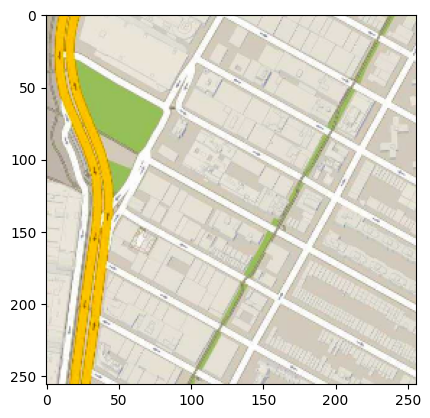

In [24]:
import matplotlib.pyplot as plt
import numpy as np

for X, y in trainloader:
    # image = X[0]
    image = y[0]

    image = image.permute(1, 2, 0).numpy()

    # Plot the image
    plt.imshow(image)
    plt.show()
    break


In [25]:
#Training loop
import random
from tqdm import tqdm


unet.train()
discriminator.train()

iters = 0

writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")


for epoch in tqdm(range(epochs)):

    for X, y in trainloader:

    
        X = X.to(ModelArgs.device)
        y = y.to(ModelArgs.device)
        
        # print(X.shape)
        # print(y.shape)
        #Train the discriminator (with real data)

        ############################
        # (1) Update D network: maximize: log(1 - D(G(z)))
        ###########################

        current_batch_size = X.shape[0]  #Getting the current batch size
        
        real_data = torch.ones((current_batch_size,), device=ModelArgs.device, dtype=torch.float32)

        # 1. Forward pass
        y_pred = discriminator(X, y).mean(dim=[2,3]).squeeze(dim=1)
        # print(y_pred)
        # print(y_pred.shape)
        # 2. Calculate  and accumulate loss
        loss_real = loss_fn(y_pred, real_data)

        # 3. Optimizer zero grad
        optimizerD.zero_grad()

       
        # loss_real.backward()


        #Train the discriminator (with fake data)

        # noise = torch.randn((batch_size, latent_vector_size, 1, 1), device=device)
        fake_data = torch.zeros(( current_batch_size,), device=ModelArgs.device, dtype=torch.float32)
        mask_generated_by_generator = unet(X)

        #1. Forward pass
        y_pred = discriminator(X,mask_generated_by_generator).mean(dim=[2,3]).squeeze(dim=1)


        # 2. Calculate  and accumulate loss
        loss_fake = loss_fn(y_pred, fake_data)


        #Accumulating total discriminator loss
        discriminator_combined_loss = -((loss_real + loss_fake) / 2)
        loss_d.append(discriminator_combined_loss.item())

         # 4. Loss backward
        discriminator_combined_loss.backward(retain_graph=True)
        
         # 5. Optimizer step
        optimizerD.step()


        ############################
        # (2) Update G network: minimize log(D(G(z)))
        ###########################

        labels = torch.ones((current_batch_size,), device=ModelArgs.device, dtype=torch.float32)

        #1. Forward pass
        y_pred = discriminator(X, mask_generated_by_generator).mean(dim=[2,3]).squeeze(dim=1)
        # y_pred = torch.argmax(probs, dim=1).type(torch.float32)


        #2. Calculate and accumulate loss
        loss_gen = loss_fn(y_pred,labels) + ModelArgs.lambda_gen * (nn.functional.l1_loss(mask_generated_by_generator, y))


        # 3. Optimizer zero grad
        optimizerG.zero_grad()

        # 4. Loss backward
        loss_gen.backward(retain_graph=True)

        # 5. Optimizer step
        optimizerG.step()

        loss_g.append(loss_gen.item())


        if iters % 100 == 0:
            print("Iterations: ", iters, "Epoch: ", epoch, "Generator loss: ", loss_gen.item(), "Discriminator loss: ", discriminator_combined_loss.item())

        #save the output
        # with torch.inference_mode():
            
            
            
        if iters % 100 == 0:
            
            print('saving the output')
            torchvision.utils.save_image(y,'{}/real_images_epoch_{}.png'.format(save_images, epoch),normalize=True)
            fake = unet(X)
            torchvision.utils.save_image(fake,'{}/fake_images_epoch_{}.png'.format(save_images, epoch),normalize=True)

            img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
            img_grid_real = torchvision.utils.make_grid(y, normalize=True)
            img_grid_map = torchvision.utils.make_grid(X, normalize=True)
                
            writer_fake.add_image(
                        "Map2erial Fake Images", img_grid_fake, global_step=iters
                    )
            writer_real.add_image(
                        "Map2Aerial Real Images", img_grid_real, global_step=iters
                    )
            
            writer_real.add_image(
                        "Map2Aerial Real Images", img_grid_map, global_step=iters
                    )
                    

            # Check pointing for every epoch
            # torch.save(generator.state_dict(), 'weights/CelebA/generator_steps_%d.pth' % (iters))
            # torch.save(discriminator.state_dict(), 'weights/CelebA/discriminator_steps_%d.pth' % (iters))


        iters += 1


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]


ValueError: Target size (torch.Size([8])) must be the same as input size (torch.Size([8, 1, 30, 30]))

In [ ]:
#For MNIST
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(loss_g,label="G")
plt.plot(loss_d,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

